<a href="https://colab.research.google.com/github/vtsimoes/class_victor_dataset/blob/main/G_VICTOR_LSTM_Bidirecional_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Redes Hierárquicas Recorrentes com mecanismo de atenção (HAN) para classificação de documentos no Dataset VICTOR



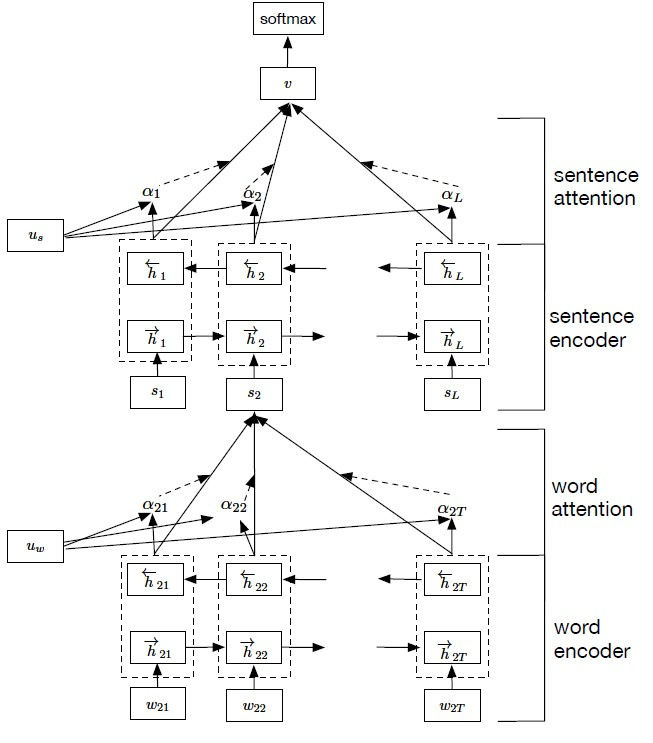

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle
import tensorflow as tf
from keras.models import Sequential, Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input
from keras.utils import to_categorical
from keras import initializers
#from keras.engine import Layer
from keras.layers import (
    Embedding, BatchNormalization,
    LSTM, SimpleRNN, GRU, RNN,
    Conv1D, MaxPooling1D,
    Bidirectional, Concatenate,
    Dense, Flatten, Dropout, Activation, Lambda, Reshape, Attention, Layer
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from os.path import join, split, splitext
import tqdm
import argparse
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from keras.utils import pad_sequences
from keras.layers import TimeDistributed
from sklearn.metrics import matthews_corrcoef
import os
import time

In [ ]:
def save_pickle(data_to_save,path='',filename='file.pkl'):
  open_file = open(path + filename, "wb")
  pickle.dump(data_to_save, open_file)
  open_file.close()

def load_pickle(path='',filename='file.pkl'):
  open_file = open(path + filename, "rb")
  pkl_file = pickle.load(open_file)
  open_file.close()
  return pkl_file

In [ ]:
DATASET = 'O100'
MAX_FEATURES = 70000
SEQUENCE_LEN = 500
MAX_PAGES = 6
NB_CLASS = 6 if DATASET != 'NO' else 5

In [ ]:
path_dados = '' #path com dados pre-processados
path_lstm_att = '' #path para salvar resultados
path_results = path_lstm_att + 'Resultados/'
path_model = 'model/'
path_dados_tokenizados = path_lstm_att + 'dados_tokenizados/' + DATASET + '/'
#Montando o google drive para obter os dados
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Carregando os conjuntos de Treino, Validação e Teste já pré-processados

In [ ]:
def get_dataset(DATASET,train,valid,test,train_O10=None,valid_O10=None):
  if DATASET == 'NO':
    train = train.loc[train.document_type != 'outros']
    valid = valid.loc[valid.document_type != 'outros']
    test = test.loc[test.document_type != 'outros']
  elif DATASET == 'O10' and train_O10 is not None and valid_O10 is not None:
    train_filename = train.loc[train.file_name.isin(train_O10)]
    train = pd.concat([train_filename,train.loc[train.document_type != 'outros']], ignore_index=True, sort=False)
    valid_filename = valid.loc[valid.file_name.isin(valid_O10)]
    valid = pd.concat([valid_filename,valid.loc[valid.document_type != 'outros']], ignore_index=True, sort=False)
  return train,valid,test

In [ ]:
train_clean = load_pickle(path=path_dados,filename='train_processed_per_page.pkl')
valid_clean = load_pickle(path=path_dados,filename='valid_processed_per_page.pkl')
test_clean = load_pickle(path=path_dados,filename='test_processed_per_page.pkl')

Separando no DATASET correspondente

In [ ]:
train_O10_filenames = load_pickle(path=path_dados,filename='filenames_train_O10.pkl')
valid_O10_filenames = load_pickle(path=path_dados,filename='filenames_valid_O10.pkl')

In [ ]:
train_clean,valid_clean,test_clean = get_dataset(DATASET,train_clean,valid_clean,test_clean,train_O10_filenames,valid_O10_filenames)

In [ ]:
len(train_clean),len(valid_clean),len(test_clean)

(149129, 94667, 95501)

## Tokenizando e gerando sequências de treinamento

In [ ]:
print("Fitting and saving tokenizer...")
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_clean["body"])

Fitting and saving tokenizer...


In [ ]:
print("Generating train sequences...")
sequences_train = tokenizer.texts_to_sequences(train_clean['body'])
print('Generating validation sequences...')
sequences_validation = tokenizer.texts_to_sequences(valid_clean['body'])
print('Generating test sequences...')
sequences_test = tokenizer.texts_to_sequences(test_clean['body'])
print('...done!')

Generating train sequences...


In [ ]:
train_clean['sequences'] = sequences_train
valid_clean['sequences'] = sequences_validation
test_clean['sequences'] = sequences_test

In [ ]:
test_clean.head(5)

Salvando as sequencias para o teste com mecanismo de atenção

In [ ]:
save_pickle(train_clean,path=path_dados_tokenizados,filename='train_text_70k_uni_sequences.pkl')
save_pickle(test_clean,path=path_dados_tokenizados,filename='test_text_70K_uni_sequences.pkl')
save_pickle(valid_clean,path=path_dados_tokenizados,filename='valid_text_70K_uni_sequences.pkl')

Caso já tenha ralizado a tokenização, começar daqui

In [ ]:
train_clean = load_pickle(path=path_dados_tokenizados,filename='train_text_70k_uni_sequences.pkl')
test_clean = load_pickle(path=path_dados_tokenizados,filename='test_text_70K_uni_sequences.pkl')
valid_clean = load_pickle(path=path_dados_tokenizados,filename='valid_text_70K_uni_sequences.pkl')

## Gerando os Tensores e Encoding Labels para treinamento

In [ ]:
def fill_data_tensor(df,MAX_PAGES,SEQUENCE_LEN):
  df.drop_duplicates(subset=['file_name','pages','document_type'],keep='first',inplace=True, ignore_index = True)
  file_list = df.groupby('file_name').agg({'pages': 'last','document_type': 'last'})
  data = np.zeros((len(file_list),MAX_PAGES,SEQUENCE_LEN),dtype='int32')
  y = []
  i=0
  for index,row in file_list.iterrows():
    df_files = df.loc[df.file_name == index]
    #for j in range(1,row.pages+1):
    for k,j in enumerate(df_files.pages):
      if  k <= MAX_PAGES - 1:
        try:
          data[i,k,] = pad_sequences(df_files.loc[df_files.pages==j].sequences, maxlen=SEQUENCE_LEN, padding='post')
        except ValueError:
          print(df_files.pages)
    y.append(row['document_type'])
    i+=1
  return data,y

In [ ]:
import time
inicio = time.time()
X_valid,y_valid = fill_data_tensor(valid_clean,MAX_PAGES,SEQUENCE_LEN)
X_test,y_test = fill_data_tensor(test_clean,MAX_PAGES,SEQUENCE_LEN)
X_train,y_train = fill_data_tensor(train_clean,MAX_PAGES,SEQUENCE_LEN)
fim = time.time()
total = (fim - inicio)
total

In [ ]:
del(train_clean)
del(valid_clean)
del(test_clean)

In [ ]:
print("Encoding labels..")
encoder = LabelEncoder()
train_label = y_train #guardando a sequência de labels com nomes por extenso
y_train = encoder.fit_transform(y_train) # transformando em números de 0 a NBCLASS - 1
y_train_onehot = to_categorical(y_train) # transformando em vetores one_hot
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights

In [ ]:
encoder.classes_

In [ ]:
print("Encoding labels..")
#Dados de Validação
valid_label = y_valid
y_valid = encoder.transform(y_valid)
y_valid_onehot = to_categorical(y_valid)

In [ ]:
#Dados de Teste
test_label = y_test
y_test = encoder.transform(y_test)
y_test_onehot = to_categorical(y_test)

In [ ]:
weight = {i : class_weights[i] for i in range(NB_CLASS)} # -1 para retirar a classe outros da contagem

In [ ]:
save_pickle(train_label,path=path_dados_tokenizados,filename='train_label_name_70K.pkl')
save_pickle(valid_label,path=path_dados_tokenizados,filename='valid_label_name_70K.pkl')
save_pickle(test_label,path=path_dados_tokenizados,filename='test_label_name_70K.pkl')
save_pickle(encoder,path=path_dados_tokenizados,filename='encoder_label_70K.pkl')
save_pickle(weight,path=path_dados_tokenizados,filename='weight_dict_70K.pkl')
save_pickle(class_weights,path=path_dados_tokenizados,filename='class_weight_70K.pkl')

In [ ]:
save_pickle(X_train,path=path_dados_tokenizados,filename='train_pad_sequences_255_6_page.pkl')
save_pickle(X_test,path=path_dados_tokenizados,filename='test_pad_sequences_255_6_page.pkl')
save_pickle(X_valid,path=path_dados_tokenizados,filename='valid_pad_sequences_255_6_page.pkl')
save_pickle(y_train,path=path_dados_tokenizados,filename='train_label_70K.pkl')
save_pickle(y_test,path=path_dados_tokenizados,filename='test_label_70K.pkl')
save_pickle(y_valid,path=path_dados_tokenizados,filename='valid_label_70K.pkl')

Recomeçar daqui caso já tenha salvo

In [ ]:
X_train = load_pickle(path=path_dados_tokenizados,filename='train_pad_sequences_255_6_page_NO.pkl')
X_test = load_pickle(path=path_dados_tokenizados,filename='test_pad_sequences_255_6_page_NO.pkl')
X_valid = load_pickle(path=path_dados_tokenizados,filename='valid_pad_sequences_255_6_page_NO.pkl')
y_train = load_pickle(path=path_dados_tokenizados,filename='train_label_70K_NO.pkl')
y_test = load_pickle(path=path_dados_tokenizados,filename='test_label_70K_NO.pkl')
y_valid = load_pickle(path=path_dados_tokenizados,filename='valid_label_70K_NO.pkl')

In [ ]:
train_label = load_pickle(path=path_dados_tokenizados,filename='train_label_name_70K_NO.pkl')
valid_label = load_pickle(path=path_dados_tokenizados,filename='valid_label_name_70K_NO.pkl')
test_label = load_pickle(path=path_dados_tokenizados,filename='test_label_name_70K_NO.pkl')
encoder = load_pickle(path=path_dados_tokenizados,filename='encoder_label_70K_NO.pkl')
weight = load_pickle(path=path_dados_tokenizados,filename='weight_dict_70K_NO.pkl')
class_weights = load_pickle(path=path_dados_tokenizados,filename='class_weight_70K_NO.pkl')
labels = encoder.classes_
y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

## Para trabalhar com camada de embedding pré-treinada Glove. Gerando matriz com vetores GloVe pré-treinados

In [ ]:
# Unzip do GloVe pré-treinado pelo NILC/USP
from zipfile import ZipFile
path_glove = '' #path com os vetores glove
file_glove = 'glove_s300.zip'
zip_nilc_glove = os.path.join(path_glove,file_glove)
with ZipFile(zip_nilc_glove, 'r') as zObject:
  zObject.extractall(path=path_glove)

In [ ]:
#coletando os vetores pré-treinados do glove e montando uma matrix
file_glove_txt = 'glove_s300.txt'
path_glove_file = os.path.join(path_glove,file_glove_txt)
embeddings_index = {}
f = open(path_glove_file, encoding='utf8')

i = 0
for line in f:
  if i == 0:
    values = line.split()
    quantidade_vocab = values[0]
    vector_size = values[1]
  else:
    values = line.split()
    word = values[0]
    try:
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    except:
      print("An exception occurred")
      print(values)

  if i%100000 == 0:
    print(i)
  i = i + 1

f.close()
print('Vocabulário original tem %s palavras.' % quantidade_vocab)
print('Encontradas %s vetores de palavras.' % len(embeddings_index))

In [ ]:
EMBED_SIZE = 300
word_index = tokenizer.word_index
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((MAX_FEATURES+1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      try:
        embedding_matrix[i] = embedding_vector
      except:
        print("An exception occurred")
        embedding_matrix[i] = np.random.standard_normal(EMBED_SIZE,)
        print(embedding_vector)
  else:
      embedding_matrix[i] = np.random.standard_normal(EMBED_SIZE,)
      absent_words += 1
  if i == MAX_FEATURES:
    print('Saindo. %s ' % str(i))
    break
print('Total de palavras não constantes no vocabulário GloVe pré-treinado', absent_words, 'o que representa', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% do total de palavras do vocabulário original')
print(str(len(word_index)-absent_words) + ' palavras foram consideradas.')

https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/

## Métodos para Cálculo das métricas

In [ ]:
#Micro recall, precision e f1
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_m_score(y_true, y_pred):
    #y_pred = np_utils.to_categorical(y_pred,num_classes=6)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return float(2*((precision*recall)/(precision+recall+K.epsilon())))

## Implementação do modelo com mecanismo de atenção

In [ ]:
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim,return_coefficients=False,**kwargs):
        self.init = initializers.get('normal')
        self.return_coefficients = return_coefficients
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1], self.attention_dim),initializer="normal", trainable = True)
        self.b=self.add_weight(name="att_bias",shape=(self.attention_dim,),initializer="normal", trainable = True)
        self.u=self.add_weight(name="u_bias",shape=(self.attention_dim,1),initializer="normal", trainable = True)

        #self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        #self.b = K.variable(self.init((self.attention_dim,)))
        #self.u = K.variable(self.init((self.attention_dim, 1)))
        #self._trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
      # size of x :[batch_size, sel_len, attention_dim]
      # size of u :[batch_size, attention_dim]
      # uit = tanh(xW+b)
      uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

      ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

      if mask is not None:
          # Cast the mask to floatX to avoid float64 upcasting
          ait *= K.cast(mask, K.floatx())
      ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
      weighted_input = x * K.expand_dims(ait)
      output = K.sum(weighted_input, axis=1)
      if self.return_coefficients:
        return [output, ait]
      else:
        return output


    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
      if self.return_coefficients:
        return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
      else:
        return input_shape[0], input_shape[-1]

## Método para gerar modelo do HAN



In [ ]:
from keras.utils import plot_model

In [ ]:
#Método para criar modelo GRU com embedding do zero
def create_model_attention_GRU(MAX_FEATURES=70000,EMBEDDING_DIM=70000,SEQUENCE_LEN=500,NB_CLASS=6,EMBEDDING_OUT = 100, learning = 0.001, UNITS = 200,MAX_PAGES=3):
  embedding_layer = Embedding(input_dim=MAX_FEATURES,
                      output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN, name="word_embedding")
  word_input = Input(shape=(SEQUENCE_LEN,), dtype='int32',name='word_input')
  word_sequences = embedding_layer(word_input)
  word_gru = Bidirectional(GRU(units=UNITS, return_sequences=True),merge_mode='concat',name="word_gru")(word_sequences)
  word_dense = Dense(2*UNITS, activation='relu', name='word_dense')(word_gru)
  word_att,word_coeffs = HierarchicalAttentionNetwork(2*UNITS,return_coefficients=True,name="word_attention")(word_dense)
  wordEncoder = Model(word_input,word_att)

  page_input = Input(shape=(MAX_PAGES,SEQUENCE_LEN), dtype='int32',name='page_input')
  page_encoder = TimeDistributed(wordEncoder,name='page_linking')(page_input)
  page_gru = Bidirectional(GRU(units=UNITS, return_sequences=True),merge_mode='concat',name="page_gru")(page_encoder)
  page_dense = Dense(2*UNITS, activation='relu', name='page_dense')(page_gru)
  page_att,page_coeffs = HierarchicalAttentionNetwork(2*UNITS,return_coefficients=True,name="page_attention")(page_dense)
  page_drop = Dropout(0.4,name='page_dropout')(page_att)
  preds = Dense(NB_CLASS,activation='softmax')(page_drop)
  model = Model(page_input,preds)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),f1_m,precision_m])
  wordEncoder.summary()
  model.summary()

  return model,wordEncoder,word_coeffs,page_coeffs

In [ ]:
#método para modelo HAN e embedding GloVe
def create_model_attention_GRU_GloVe(MAX_FEATURES=70000,EMBEDDING_DIM=70000,SEQUENCE_LEN=500,NB_CLASS=6,EMBEDDING_OUT = 100, learning = 0.001, UNITS = 200,MAX_PAGES=3,embedding_matrix=None):

  embedding_layer = Embedding(input_dim=MAX_FEATURES+1,output_dim=EMBEDDING_OUT,weights=[embedding_matrix],input_length=SEQUENCE_LEN, trainable=True,name='word_embedding')
  word_input = Input(shape=(SEQUENCE_LEN,), dtype='int32',name='word_input')
  word_sequences = embedding_layer(word_input)
  word_gru = Bidirectional(GRU(units=UNITS, return_sequences=True),merge_mode='concat',name="word_gru")(word_sequences)
  word_dense = Dense(2*UNITS, activation='relu', name='word_dense')(word_gru)
  word_att,word_coeffs = HierarchicalAttentionNetwork(2*UNITS,return_coefficients=True,name="word_attention")(word_dense)
  wordEncoder = Model(word_input,word_att)

  page_input = Input(shape=(MAX_PAGES,SEQUENCE_LEN), dtype='int32',name='page_input')
  page_encoder = TimeDistributed(wordEncoder,name='page_linking')(page_input)
  page_gru = Bidirectional(GRU(units=UNITS, return_sequences=True),merge_mode='concat',name="page_gru")(page_encoder)
  page_dense = Dense(2*UNITS, activation='relu', name='page_dense')(page_gru)
  page_att,page_coeffs = HierarchicalAttentionNetwork(2*UNITS,return_coefficients=True,name="page_attention")(page_dense)
  page_drop = Dropout(0.4,name='page_dropout')(page_att)
  preds = Dense(NB_CLASS,activation='softmax')(page_drop)
  model = Model(page_input,preds)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),f1_m,precision_m])
  wordEncoder.summary()
  model.summary()
  return model,wordEncoder,word_coeffs,page_coeffs,page_input,word_input

Método para capturar a saída da representação do documentos antes da camada densa de classificação

In [ ]:
#Função para pegar o estado interno
def get_layer_output(model,idx_layer,x):
  layer = K.function([model.layers[0].input],[model.layers[idx_layer].output])
  output = layer([x])[0]

### Callbacks

In [ ]:
def config_callbacks(path):
  model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
  )
  return model_checkpoint_cb,early_stopping_cb


In [ ]:
def config_experiment(batch,unit):
  CLASSIFICADOR = 'GRU'
  EMBEDDING_DIM = MAX_FEATURES  # Size of vocabulary
  UNITS = unit  # Number of output cells for Recurrent Models
  EMBEDDING_OUT = 200  # Output dim of embedding
  BATCH_SIZE = batch
  EPOCHS = 20
  GRAM = 'GLOVE'
  NOME_RUNNING = f'{CLASSIFICADOR}-{SEQUENCE_LEN}-{MAX_PAGES}-{EMBEDDING_OUT}-{UNITS}-{BATCH_SIZE}-{GRAM}-{DATASET}'
  experiment = {'CLASSIFICADOR':CLASSIFICADOR,'MAX_FEATURES':MAX_FEATURES,'EMBEDDING_OUT':EMBEDDING_OUT,'UNITS':UNITS,'BATCH_SIZE':BATCH_SIZE,'GRAM':GRAM}
  path_experiment = path_results + 'tunning/' + NOME_RUNNING +'/'
  path_checkpoint = path_experiment+'/' + path_model
  if not os.path.exists(path_experiment):
    os.makedirs(path_experiment)
  checkpoint_cb,early_cb = config_callbacks(path_checkpoint)
  return EPOCHS,UNITS,EMBEDDING_DIM,EMBEDDING_OUT,BATCH_SIZE,EPOCHS,GRAM,NOME_RUNNING,experiment,path_experiment,checkpoint_cb,early_cb

## Seleção de Hiperparâmetros

In [ ]:
BATCHES = [64,32]
UNITS = [100,150,200]
grid = [(batch,unit) for batch in BATCHES for unit in UNITS]
grid

[(64, 100), (64, 150), (64, 200), (32, 100), (32, 150), (32, 200)]

In [ ]:
best_unit = ""
best_batch = ""
total_best_val_loss = 10000
best_experiment_name = ""
total_results = []
for batch,unit in grid:
  results = {}
  EPOCHS,UNITS,EMBEDDING_DIM,EMBEDDING_OUT,BATCH_SIZE,EPOCHS,GRAM,NOME_RUNNING,experiment,path_experiment,checkpoint_cb,early_cb = config_experiment(batch,unit)
  np.random.seed(42)
  tf.random.set_seed(42)
  model,wordEncoder,word_coeffs,page_coeffs = create_model_attention_GRU(MAX_FEATURES,EMBEDDING_DIM,SEQUENCE_LEN=SEQUENCE_LEN,NB_CLASS=NB_CLASS,EMBEDDING_OUT = EMBEDDING_OUT, learning = 0.001, UNITS = unit,MAX_PAGES=MAX_PAGES)
  time_start = time.time()
  history = model.fit(
    X_train, y_train_onehot,
    batch_size=batch,
    validation_data=(X_valid, y_valid_onehot),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_cb,checkpoint_cb],
    class_weight=weight
  )
  time_end = time.time()
  total_time = time_end-time_start
  best_val_loss = np.min(history.history['val_loss'])
  best_epoc = np.argmin(history.history['val_loss']) + 1
  best_loss = np.min(history.history['loss'])
  results = {'history':history.history,'experiment':NOME_RUNNING,'config':experiment,'best_val_loss':best_val_loss,'best_loss':best_loss, 'best_epoc':best_epoc,'time':total_time,'UNITS':unit,'BATCH_SIZE':batch,'path':path_experiment}
  total_results.append(results)
  save_pickle(results,path=path_experiment,filename='results.pkl')
  if best_val_loss < total_best_val_loss:
    total_best_val_loss = best_val_loss
    best_unit = unit
    best_batch = batch
    best_experiment_name = experiment

In [ ]:
print("Best UNITS: " + str(best_unit))
print("Best BATCH: " + str(best_batch))
print("Best val_loss: " + str(total_best_val_loss))

Best UNITS: 200
Best BATCH: 32
Best val_loss: 0.24493248760700226


In [ ]:
save_pickle(results,path=path_results+'/tunning/',filename='GRU_O10_tunning_21-07-2023.pkl')

## Treinamento do Modelo

In [ ]:
X_test.shape,X_train.shape,X_valid.shape

((25300, 6, 500), (38814, 6, 500), (25448, 6, 500))

In [ ]:
CLASSIFICADOR = 'GRU'
EMBEDDING_DIM = MAX_FEATURES  # Size of vocabulary
UNITS = 100  # Number of output cells for Recurrent Models
EMBEDDING_OUT = 300  # Output dim of embedding
BATCH_SIZE = 32
EPOCHS = 20
GRAM = 'GLOVE'
NOME_RUNNING = f'{CLASSIFICADOR}-{SEQUENCE_LEN}-{MAX_PAGES}-{EMBEDDING_OUT}-{UNITS}-{BATCH_SIZE}-{GRAM}-{DATASET}'
experiment = {'CLASSIFICADOR':CLASSIFICADOR,'MAX_FEATURES':MAX_FEATURES,'EMBEDDING_OUT':EMBEDDING_OUT,'UNITS':UNITS,'BATCH_SIZE':BATCH_SIZE,'GRAM':GRAM}
path_experiment = path_results + NOME_RUNNING + '/'

'GRU-255-6-300-100-32-GLOVE-NO'

In [ ]:
if not os.path.exists(path_experiment):
  os.makedirs(path_experiment)

In [ ]:
path_checkpoint = path_experiment+'/' + path_model
checkpoint_cb,early_cb = config_callbacks(path_checkpoint)

'drive/MyDrive/MestradoTucurui/Experiments/LSTM-Attention/Resultados/GRU-255-6-300-100-32-GLOVE-NO//model/'

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
if CLASSIFICADOR == 'GRU':
  model,wordEncoder,word_coeffs,page_coeffs = create_model_attention_GRU(MAX_FEATURES,EMBEDDING_DIM,SEQUENCE_LEN=SEQUENCE_LEN,NB_CLASS=NB_CLASS,EMBEDDING_OUT = EMBEDDING_OUT, learning = 0.001, UNITS = UNITS,MAX_PAGES=MAX_PAGES)
else:
  model,_ = model,wordEncoder,word_coeffs,page_coeffs,page_input,word_input = create_model_attention_GRU_GloVe(MAX_FEATURES,EMBEDDING_DIM,SEQUENCE_LEN=SEQUENCE_LEN,NB_CLASS=NB_CLASS,EMBEDDING_OUT = EMBEDDING_OUT, learning = 0.001, UNITS = UNITS,MAX_PAGES=MAX_PAGES,embedding_matrix=embedding_matrix)
  print('GloVe')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
model,wordEncoder,word_coeffs,page_coeffs,page_input,word_input = create_model_attention_GRU_GloVe(MAX_FEATURES,EMBEDDING_DIM,SEQUENCE_LEN=SEQUENCE_LEN,NB_CLASS=NB_CLASS,EMBEDDING_OUT = EMBEDDING_OUT, learning = 0.001, UNITS = UNITS,MAX_PAGES=MAX_PAGES,embedding_matrix=embedding_matrix)

In [ ]:
time_start = time.time()
history = model.fit(
    X_train, y_train_onehot,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid_onehot),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_cb,checkpoint_cb],
    class_weight=weight
)
time_end = time.time()

In [ ]:
tempo_total = time_end-time_start
tempo_total

237.4179859161377

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss))
epochs

range(1, 10)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,label='Treino')
plt.plot(epochs,val_loss,label='Validação')
plt.legend(loc="upper right")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,label='Treino')
plt.plot(epochs,val_acc,label='Validação')
plt.legend(loc="lower right")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.grid()
plt.show()

In [ ]:
model.load_weights(path_checkpoint) #carregando os pesos do EarlyStopping


## Aplicando o modelo treinado no conjunto de Testes

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#função para resumo dos resultados
def print_results(report,f1,mcc_test,time_process):
  print(report)
  print("F1-score Médio de Teste : " + str(f1))
  print("MCC de Teste: " + str(mcc_test))
  print("Tempo de processamento total: " + str(time_process) + ' s')

In [ ]:
#método que retorna os índices salvos. Os valores devem ser nomeados de acordo com a classe
def calculate_metrics(y_true,y_pred,history):
  f1score = f1_score(y_true, y_pred,average='macro')
  scores = precision_recall_fscore_support(y_true, y_pred,average=None)
  confusion = confusion_matrix(y_true, y_pred)
  report = classification_report(test_label,y_pred,digits=5)
  report_as_dict = classification_report(test_label,y_pred,digits=5,output_dict=True)
  mcc_test = matthews_corrcoef(test_label,y_pred)
  loss = {'val_loss':history.history['val_loss'],'loss':history.history['loss'],'acc':history.history['accuracy'],'val_acc':history.history['val_accuracy']}
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(y_true,y_pred,values_format='.2f',normalize='true',ax=ax,xticks_rotation='vertical')
  return f1score,scores,confusion,report,report_as_dict,mcc_test,loss

In [ ]:
def saveModelResults(conf,f1,scores,time,classes,report,mcc,experimento,report_as_dicts,path,y_pred,y_true,loss,tipo="results"):
  score = {'confusion':conf,'f1score':f1,'scores':scores,'mcc_test':mcc,'time':time,'report':report, 'report_as_dict':report_as_dicts,'experimento': experimento,'classes':classes,'y_pred':y_pred,'y_true':y_true}
  filename = tipo+'.pkl'
  save_pickle(score,path=path,filename=filename)
  return score

In [ ]:
time_infer_start = time.time()
predict = model.predict(X_test) #usar predict_classes
time_infer_end = time.time()
time_infer = (time_infer_end - time_infer_start)/len(X_test)
test_pred = predict.argmax(axis=1)
test_pred_label = encoder.inverse_transform(test_pred)

35/35 [==============================] - 3s 26ms/step


In [ ]:
f1score,scores,confusion,report,report_as_dict,mcc_test,loss = calculate_metrics(test_label,test_pred_label,history)

In [ ]:
print_results(report,f1score,mcc_test,0)

In [ ]:
tempo = {'train':tempo_total,'infer':time_infer}
dict_results = saveModelResults(confusion,f1score,scores,tempo,encoder.classes_,report,mcc_test,NOME_RUNNING,report_as_dict,path_experiment,test_pred_label,test_label,loss,tipo="results")